In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numba import njit

In [2]:
normal_dist = lambda x, m, s: 1 / (np.sqrt(2*np.pi) * s) * np.exp(-1/2 * ((x - m) / s)**2)

@njit
def b_maxL_2(m, t, C):
    first = C[0]+C[1]-(m[0]+m[1])*(t[0]+t[1])
    root = (C[0]+C[1]+(m[0]-m[1])*(t[0]+t[1]))**2-4*C[0]*(m[0]-m[1])*(t[0]+t[1])
    res = (first+np.sqrt(root))/(2*(t[0]+t[1]))
    if res < 0:
        return 0
    return res

In [3]:
# true incoming rates
s1 = 200.
s2 = 100.
b = 300.

# include time, even though rates = counts here, only included so that b_max_L doesn't have to be rewritten
t1 = 1.
t2 = 1.

true_counts = np.array([s1, s2, b, b])
cluster_size = 2

# How many posterior samples
num_posterior_samples = 300
# How many predictive samples, equivalent to number of real data bins in real analysis
num_predictive_samples = 1000
# Bins in plot
num_bins = 100

# standard deviation of posterior
posterior_std = np.array([5., 5.])
# samples of posterior
posterior_samples = np.random.normal(true_counts[:cluster_size], posterior_std, size=(num_posterior_samples, cluster_size))

# Each posterior sample is sampled into the predictive samples
posterior_predictive_source_counts = np.random.poisson(posterior_samples, (num_predictive_samples, num_posterior_samples, cluster_size))
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(0, 1)
# posterior_predictive_source_counts = posterior_predictive_source_counts.swapaxes(1, 2)

# actual measured counts, available to use in analysis
measured_counts = np.random.poisson(true_counts, (num_predictive_samples, len(true_counts)))
measured_counts_combined = measured_counts[:,:cluster_size] + measured_counts[:,cluster_size:]

# maximum likelihood background
b_max_L = np.zeros((num_predictive_samples, num_posterior_samples))
for i in range(num_posterior_samples):
    for j in range(num_predictive_samples):
        b_max_L[j, i] = b_maxL_2(posterior_samples[i], [t1, t2], measured_counts_combined[j])
# n, bins, _ = plt.hist(b_max_L.flatten(), bins=num_bins)
# x = bins
# y = normal_dist(bins, b, np.sqrt(b))
# y = y * np.amax(n) / np.amax(y)
# plt.plot(x, y)


/home/moej56153/.pyenv/versions/MT/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 't' of function 'b_maxL_2'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_605/841175681.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [4]:
# Repeat for easier usage
posterior_predictive_background_counts = np.repeat(b_max_L[:,:,np.newaxis], 2, axis=2)
# Sample posterior predictive counts
posterior_predictive_counts = np.random.poisson(posterior_predictive_background_counts + posterior_predictive_source_counts)

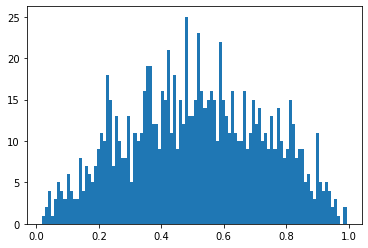

In [5]:
# Sort posterior predictive counts for each predictive sample, i.e. sort posterior samples
argsort = np.argsort(posterior_predictive_counts, axis=1)
total = np.take_along_axis(posterior_predictive_counts, argsort, axis=1)

# Find placement of measured counts in sorted array
cdf = np.zeros(num_predictive_samples)
for i in range(num_predictive_samples):
    cdf[i] = ((np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "left")
                     + np.searchsorted(total[i,:,0], measured_counts_combined[i, 0], "right"))
                     / (2 * num_posterior_samples))
    
_ = plt.hist(cdf, bins=num_bins)


In [8]:
@njit
def calc_bmaxL_variance_matrix(b_array, s1_array, t1_array, s2_array, t2_array, num_samples=10000):
    variance_matrix = np.zeros((len(b_array), len(s1_array), len(t1_array), len(s2_array), len(t2_array)))
    for b_i, b in enumerate(b_array):
        for s1_i, s1 in enumerate(s1_array):
            for t1_i, t1 in enumerate(t1_array):
                for s2_i, s2 in enumerate(s2_array):
                    for t2_i, t2 in enumerate(t2_array):
                        bs = np.zeros(num_samples)
                        for n_i in range(num_samples):
                            s1n = np.random.poisson(s1)
                            s2n = np.random.poisson(s2)
                            c1n = s1n + np.random.poisson(b)
                            c2n = s2n + np.random.poisson(b)
                            bs[n_i] = b_maxL_2(np.array([s1n, s2n]), np.array([t1, t2]), np.array([c1n, c2n]))
                        if b_i == 2 and s1_i == 2 and s2_i == 2:
                            print(bs)
                            print(b, s1, t1, s2, t2)
                            print(s1n, s2n, c1n, c2n)
                            print(b_maxL_2([s1n, s2n], [t1, t2], [c1n, c2n]))
                        variance_matrix[b_i, s1_i, t1_i, s2_i, t2_i] = np.var(bs)
    return variance_matrix

In [9]:
input_b = np.geomspace(1,1000,3)
input_s1 = np.geomspace(1,1000,3)
input_t1 = np.geomspace(600, 6000, 1)
input_s2 = np.geomspace(1,1000,3)
input_t2 = np.geomspace(600, 6000, 1)

In [10]:
v = calc_bmaxL_variance_matrix(input_b, input_s1, input_t1, input_s2, input_t2)

[0. 0. 0. ... 0. 0. 0.]
1000.0 1000.0 600.0 1000.0 600.0
960 1053 1979 2046
0.0


In [11]:
v[2, 2, 0, 2, 0]

0.0

In [17]:
b_maxL_2(np.array([960 ,1053 ]), np.array([1. ,1.]),np.array([1979.,2046.]))

1006.3003278525123